In [44]:
import pandas as pd
import numpy as np
import datetime
from pandas_datareader import data as web
import glob
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
%matplotlib inline

# Prepare data

In [7]:
#Load Google Trends data
files = glob.glob("GoogleTrends/*.csv")

#look at first file and get location of last entry, as well as the dates
GT = pd.read_csv(files[0],header=4,skip_blank_lines=False)
tail = np.where(pd.isnull(GT))[0][0]-2

#get dates in integer and string format for each friday (gotta get down on friday)
GT_dates_int = []
GT_dates_str = []
for date in GT.loc[0:tail].iterrows():
    d = date[1][0].split(" - ")[1].split("-")
    GT_dates_int.append(int(d[0]+d[1]+d[2])-1)
    day = int(d[2])-1
    if day < 10:
        day = "0"+str(day)
    else:
        day = str(day)
    GT_dates_str.append(d[0]+"-"+d[1]+"-"+day)

In [20]:
#load all Google Trends data
cols = [] 
for f in files:
    df = pd.read_csv(f,header=None,skiprows=4,skip_blank_lines=False)
    df = df.loc[0:tail+1]
    cols.append(df.iloc[:,1])
GT = pd.concat(cols,axis=1,names=cols)
GT.columns = GT.iloc[0]
GT = GT.iloc[1:].astype(float)
GT = GT.reset_index(drop=True)

In [21]:
#how you want to prepare your GT data (simple difference, difference from rolling average, etc)
choice = "rolling_diff"
dt = 4

if choice == "diff":
    GT = GT.diff()
    dt = 1
elif choice == "rolling_diff":
    rolling = GT.rolling(window=dt).mean()
    GT = GT - rolling
    
#get dates
GT.insert(0,"Dates",GT_dates_int)
GT = GT.iloc[dt:]

In [23]:
#Get all S&P500 data
t0 = [int(x) for x in GT_dates_str[0].split("-")]    #start of Google Trends
t1 = [int(x) for x in GT_dates_str[-1].split("-")]   #End of Google Trends
start = datetime.datetime(t0[0], t0[1], t0[2])
end = datetime.datetime(t1[0], t1[1], t1[2])
data = web.DataReader('^GSPC','yahoo', start, end)
stock_dates = []

#get dates in integer form
for date in data.iterrows():
    d = str(date[0].date()).split("-")
    stock_dates.append(int(d[0]+d[1]+d[2]))

#Take closing prices (i.e. end of week) only on dates coresponding to Google Trend dates
data.insert(0,"Dates",stock_dates)
data = data.loc[data["Dates"].isin(GT_dates_int)]

#get change in price, much more predictive
data["Weekly Change"] = data["Adj Close"].diff() 
data = data.iloc[dt:]

#ensure that Google Trends data aligns with stock data too
GT = GT[GT["Dates"].isin(data["Dates"])]

In [24]:
#data
y = data["Weekly Change"]
ys = (y - np.mean(y))/np.std(y)

(300, 400)

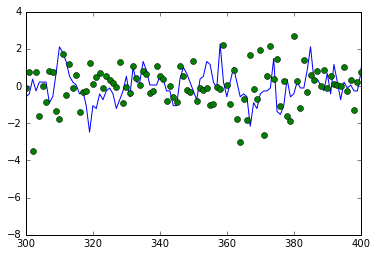

In [29]:
#sample plotting option
fieldx = "car"
fieldy = "Weekly Change"
tt = range(len(GT[fieldx]))
yy = (data[fieldy] - data[fieldy].mean())/data[fieldy].std()
xx = (GT[fieldx] - GT[fieldx].mean())/GT[fieldx].std()

plt.plot(tt,xx)
plt.plot(tt,yy,'o')
#plt.ylim([-6,6])
plt.xlim([300,400])

# PCA

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_PCA = StandardScaler().fit_transform(GT[GT.columns[1:]]) #scale data

pca = PCA(n_components=3)
pca.fit(X_PCA)                 #get PCs of scaled data
print "The principal components explain "+np.array_str(pca.explained_variance_ratio_)+" of the variance in the data."
pd.DataFrame(pca.components_.T, index=GT.columns[1:])

The principal components explain [ 0.30293493  0.11996879  0.07238457] of the variance in the data.


,0,1,2
0,,,
bonds,-0.203137,0.186396,-0.244912
car,-0.034577,0.462587,0.241317
crash,-0.025448,0.186302,0.437308
debt,-0.213764,0.203355,0.037997
economics,-0.401212,-0.173374,-0.036879
economy,-0.404490,-0.095853,0.054556
escape,0.141954,0.304589,0.197522
inflation,-0.385901,-0.130394,0.133066
market,-0.122978,0.166881,0.524376


# Onto Machine Learning

## Linear Regression

In [39]:
int(N*(1-test_size))

515

In [60]:
from sklearn import linear_model
test_size = 0.15  #want a clean split, not equal sampling throughout time series

columns = ["risk","inflation","metals","economics","debt","economy","car"]
Xs = StandardScaler().fit_transform(GT[columns])
N = len(y)
split = int(N*(1-test_size))
Xs_train, Xs_test, ys_train, ys_test = Xs[0:split], Xs[split:], ys[0:split], ys[split:] #scaled data

regr = linear_model.LinearRegression()
regr.fit(Xs_train, ys_train)
print "coefficient of determination R^2 of the prediction:",regr.score(Xs_test, ys_test)
print "MSE is:",cross_val_score(regr, Xs_test, ys_test, scoring='mean_squared_error').mean()
print "\nModel coefficients are:" 
for i in range(len(columns)):
    print("%s\t\t%f" % (columns[i], regr.coef_[i]))

coefficient of determination R^2 of the prediction: 0.0204822673805
MSE is: -1.63937083571

Model coefficients are:
risk		0.142655
inflation		-0.001218
metals		0.018433
economics		0.060764
debt		-0.067427
economy		-0.250075
car		-0.055911


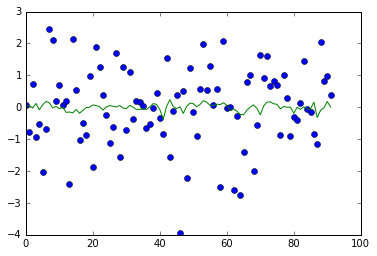

In [51]:
t = range(len(ys_test))
plt.plot(t, ys_test, 'o')
plt.plot(t,regr.predict(Xs_test))

## Random Forest

In [31]:
columns = GT.columns[1:]
X = GT[columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
rfr = RandomForestRegressor(max_features='auto' ,n_estimators=50, oob_score=1) 
param_grid = { 
        'n_estimators': [300,500],
        'max_features': ['sqrt'],
        'min_samples_split': [2,4,8,12,16]
}
CV_rfr = GridSearchCV(n_jobs=-1, estimator=rfr, scoring="mean_squared_error", param_grid=param_grid)
CV_rfr.fit(X_train, y_train);
print("Best Parameters from gridsearch: {%s} with a score of %0.4f" % (CV_rfr.best_params_, CV_rfr.best_score_))

Best Parameters from gridsearch: {{'max_features': 'sqrt', 'min_samples_split': 12, 'n_estimators': 300}} with a score of -872.9191


In [32]:
modelrfr = CV_rfr.best_estimator_
print("Feature\t\tImportance\n")
for i in reversed(np.argsort(modelrfr.feature_importances_)):
    print("%s\t\t%f" % (columns[i], modelrfr.feature_importances_[i]))

Feature		Importance

market		0.148598
crash		0.090362
unemployment		0.071609
party		0.070783
escape		0.059799
inflation		0.057886
bonds		0.057710
economics		0.054554
economy		0.054357
risk		0.053645
suicide		0.051415
debt		0.050203
metals		0.047832
panic		0.047159
money		0.047076
car		0.037014
